In [1]:
!pip install toolz tqdm keras opencv-python


In [2]:
from __future__ import print_function
from PIL import Image
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('classic')

from tqdm import tqdm

from skimage.io import imread
from skimage.transform import resize as imresize

from keras.preprocessing.image import img_to_array
from keras.layers import Conv2D, UpSampling2D, InputLayer, MaxPool2D
from keras.models import Sequential
from keras.optimizers import RMSprop

Using TensorFlow backend.


### Data loading

In [0]:
from toolz import compose
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle


"""
  Load (pickled) data files from Google Drive
"""

auth.authenticate_user()
drive_service = build('drive', 'v3')


def create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def download_file_bytes(request):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
      # _ is a placeholder for a progress object that we ignore.
      # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()

    downloaded.seek(0)
    return downloaded.read()


def save_to_vm_drive(file_bytes, save_to):
    with open(save_to, "wb") as f:
        f.write(file_bytes)


def load_from_vm_drive(load_from):
    return pickle.load(open(load_from, "rb"))


def save_data(file_ids, file_dests):
    for file_id, dest in zip(file_ids, file_dests):
        file_bytes = compose(download_file_bytes, create_file_request)(file_id)
        save_to_vm_drive(file_bytes, dest)


def load_data(file_dests):
    for dest in file_dests:
        yield load_from_vm_drive(dest)

In [0]:
import cv2

We'll use the general idea from [How to colorize black & white photos with just 100 lines of neural network code
](https://medium.freecodecamp.org/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d) blog post, so we need to define conversion between RGB and LAB colorspaces. 

In [0]:
def rgb2lab(img):
  return cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

def lab2rgb(img):
  return cv2.cvtColor(img, cv2.COLOR_LAB2RGB)



!mkdir -p images
!wget -P images http://www.warsawtour.pl/sites/default/files/imagecache/atrakcja_big/repozytorium/zdjecia/ciekawe_miejsca/pkin_caly.jpg

We'll try to reconstruct color image from only its luminance (grayscale) channel (L from LAB).

In [6]:
# Get image
image = img_to_array(imread('images/pkin_caly.jpg'))
image = np.array(image, dtype='uint8')
image.shape

(371, 556, 3)

In [0]:
image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

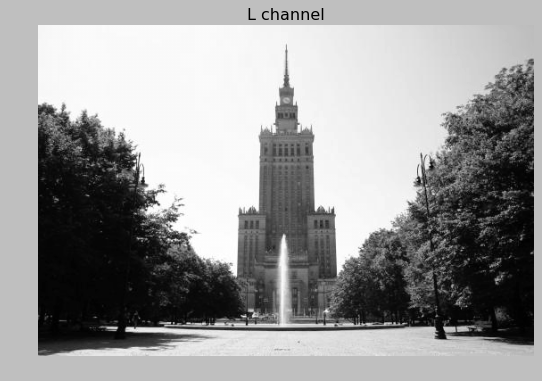

In [8]:
plt.title('L channel')
plt.imshow(image_lab[:, :, 0], cmap='gray')
plt.axis('off')
plt.show()

In [9]:
# Import map images into the lab colorspace
input_shape = (384, 576)

input_image = imresize(rgb2lab(image), input_shape)

X = input_image[:,:,0]
Y = input_image[:, :, 1:]
X = X.reshape((1, *X.shape, 1))
Y = np.expand_dims(Y, 0)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:

# Building the neural network
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='sigmoid', padding='same'))

# Finish model
model.compile(optimizer=RMSprop(decay=0.05),loss='mse')


In [11]:
%%time
#Train the neural network
model.fit(x=X, y=Y, batch_size=1, epochs=100)
print(model.evaluate(X, Y, batch_size=1))


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.0016
Epoch 2/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0014
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0013
Epoch 4/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0013
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0014
Epoch 6/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0012
Epoch 7/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0011
Epoch 8/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0012
Epoch 9/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0013
Epoch 10/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0011
Epoch 11/100
1/1 [==============================] - 0s 37ms/step - loss: 9.9833e-04
Epoch 12/100
1/1 [==============================] - 0s 38ms/step - loss: 9.7838e-04
Epoch 13/100
1/1 [=========================

Epoch 34/100
1/1 [==============================] - 0s 39ms/step - loss: 5.8224e-04
Epoch 35/100
1/1 [==============================] - 0s 40ms/step - loss: 5.8425e-04
Epoch 36/100
1/1 [==============================] - 0s 39ms/step - loss: 6.1202e-04
Epoch 37/100
1/1 [==============================] - 0s 39ms/step - loss: 6.6716e-04
Epoch 38/100
1/1 [==============================] - 0s 39ms/step - loss: 7.4769e-04
Epoch 39/100
1/1 [==============================] - 0s 39ms/step - loss: 6.0899e-04
Epoch 40/100
1/1 [==============================] - 0s 41ms/step - loss: 6.0397e-04
Epoch 41/100
1/1 [==============================] - 0s 38ms/step - loss: 5.7878e-04
Epoch 42/100
1/1 [==============================] - 0s 45ms/step - loss: 5.8004e-04
Epoch 43/100
1/1 [==============================] - 0s 39ms/step - loss: 5.7040e-04
Epoch 44/100
1/1 [==============================] - 0s 39ms/step - loss: 5.7887e-04
Epoch 45/100
1/1 [==============================] - 0s 40ms/step - loss: 5.7

Epoch 68/100
1/1 [==============================] - 0s 44ms/step - loss: 5.1454e-04
Epoch 69/100
1/1 [==============================] - 0s 40ms/step - loss: 5.0825e-04
Epoch 70/100
1/1 [==============================] - 0s 39ms/step - loss: 5.1117e-04
Epoch 71/100
1/1 [==============================] - 0s 39ms/step - loss: 5.0194e-04
Epoch 72/100
1/1 [==============================] - 0s 41ms/step - loss: 5.0468e-04
Epoch 73/100
1/1 [==============================] - 0s 38ms/step - loss: 4.9869e-04
Epoch 74/100
1/1 [==============================] - 0s 40ms/step - loss: 5.0175e-04
Epoch 75/100
1/1 [==============================] - 0s 40ms/step - loss: 4.9497e-04
Epoch 76/100
1/1 [==============================] - 0s 39ms/step - loss: 4.9747e-04
Epoch 77/100
1/1 [==============================] - 0s 41ms/step - loss: 4.9109e-04
Epoch 78/100
1/1 [==============================] - 0s 40ms/step - loss: 4.9265e-04
Epoch 79/100
1/1 [==============================] - 0s 39ms/step - loss: 4.8

In [12]:
# Output colorizations
output = model.predict(X)

canvas = np.concatenate([X, output], axis=-1)[0]
canvas.shape

(384, 576, 3)

In [0]:
retrieved_image = lab2rgb(np.array(canvas * 255, dtype='uint8'))

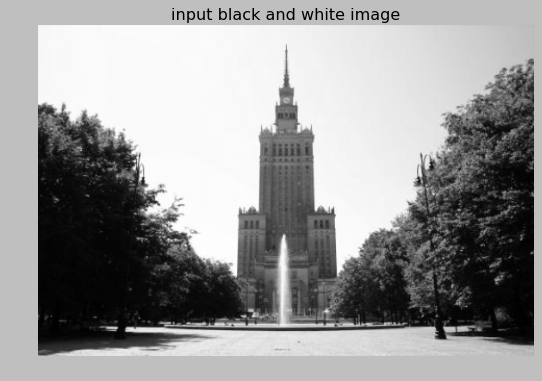

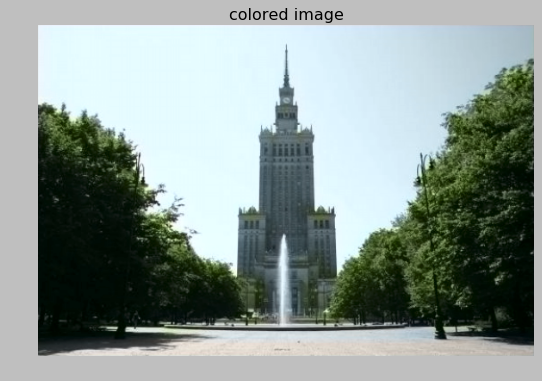

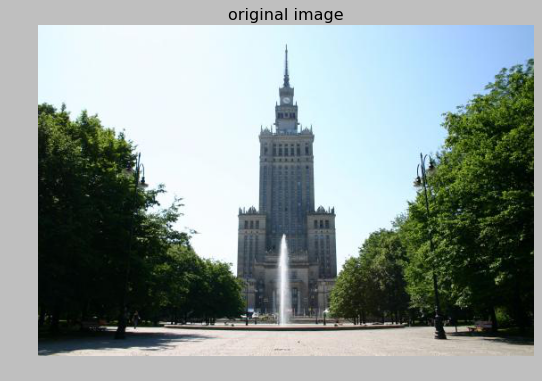

In [14]:
plt.title('input black and white image')
plt.imshow(X[0][:, :, 0], cmap='gray')
plt.axis('off')
plt.show()

plt.title('colored image')
plt.imshow(retrieved_image)
plt.axis('off')
plt.show()


plt.title('original image')
plt.imshow(image)
plt.axis('off')
plt.show()